In [2]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [1]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 4.7MB/s 
     |████████████████████████████████| 92kB 9.2MB/s 


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import csv
from csv import reader
from csv import DictReader
% matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [39]:
# Upload the train file
from google.colab import files
uploaded = files.upload()

Saving all_movies_check.csv to all_movies_check.csv
Saving all_movies.csv to all_movies.csv


In [40]:
uploaded = files.upload()

Saving genre_defs.csv to genre_defs.csv


In [41]:
#In order to run movies remove the #:
df = pd.read_csv("all_movies.csv")
df_genres = pd.read_csv("genre_defs.csv")

#In order to run books remove the #:
#df_books = pd.read_csv("books_train.csv")
#df_genres_b = pd.read_csv("geners_def_books.csv")
#df_gen = pd.read_csv("Book1.csv")

In [42]:
df.shape
df.sample(2)

,Title,Year,Rated,Released,Runtime,Genre1,Genre2,Genre3,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings.Source,Ratings.Value,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response,tomatoURL,Action
2741,Woo,1998,R,08-May-98,84 min,Comedy,Romance,NaN,Daisy von Scherler Mayer,David C. Johnson,"Jada Pinkett Smith, Tommy Davidson, Duane Mart...",Gorgeous and extravert Woo meets insecure and ...,English,USA,NaN,https://images-na.ssl-images-amazon.com/images...,Internet Movie Database,3.9/10,NaN,3.9,"1,576",tt0120531,movie,13-Jan-04,NaN,New Line Home Entertainment,NaN,True,http://www.rottentomatoes.com/m/woo/,FALSE
2772,Dancer in the Dark,2000,R,06-Oct-00,140 min,Crime,Drama,Musical,Lars von Trier,Lars von Trier,"Björk, Catherine Deneuve, David Morse, Peter S...",An east European girl goes to America with her...,"English, German, Czech","Denmark, Spain, Germany, Netherlands, Italy, U...",Nominated for 1 Oscar. Another 33 wins & 46 no...,https://images-na.ssl-images-amazon.com/images...,Internet Movie Database,8.0/10,61.0,8.0,"83,814",tt0168629,movie,20-Mar-01,"$2,839,256",Fine Line Features,http://dancerinthedark.com,True,http://www.rottentomatoes.com/m/dancer_in_the_...,FALSE


The following 3 boxes are to be run only if you want to train the model on books

In [10]:
len_genres = df_gen["value"].count() 

num_books = df_books["0"].count()

len_def = df_genres_b["Genre"].count()

d_books={} 
for k in range (len_def):
  d_books[df_genres_b["Genre"][k]]=0
  
for i in range(num_books):
  genres=df_books["1"][i]
  d={}
  genres_array = genres.split(", ")
  num_genres = (genres).count(",")+1
  #print(gener_array_split)
  for genre in range (num_genres):
    for j in range (len_genres):
      if (str(genres_array[genre])==str(df_gen["value"][j])):
        d[df_gen["Genre1"][j]]= genres_array[genre]
        if (len(str(df_gen["Genre2"][j]))>3):
          d[df_gen["Genre2"][j]]=genres_array[genre]
          if (len(str(df_gen["Genre3"][j]))>3):
            d[df_gen["Genre3"][j]]=genres_array[genre]
  for k in d:
    d_books[k]+=1

print(d_books)

{'Adventure Books': 423, 'Memoirs/ Biography': 322, 'Funny Books & Stories': 581, 'Crime': 179, 'Fantasy': 450, 'Historical': 207, 'Horror': 246, 'Mystery': 107, 'Romance': 590, 'Science Fiction': 200, 'Short Story Books': 99, 'Thrillers': 524, 'War Books': 60, 'Young Adults': 182, "Children's Books": 1073, 'Fiction': 802, 'Graphic Novels': 195, 'Holocaust': 47, 'True Story Books': 150}


In [11]:
pos_data = 0
neg_data = 0
examples = []
labels = []
#genres = []
#n={}

stop_dict = {}
for k in range (len_def):
  stop_dict[df_genres_b["Genre"][k]]=0
  
for i in range(num_books):
  genres=df_books["1"][i]
  d={}
  genres_array = genres.split(", ")
  num_genres = (genres).count(",")+1
  #print(gener_array_split)
  for genre in range (num_genres):
    for j in range (len_genres):
      if (str(genres_array[genre])==str(df_gen["value"][j])):
        d[df_gen["Genre1"][j]]= genres_array[genre]
        if (len(str(df_gen["Genre2"][j]))>3):
          d[df_gen["Genre2"][j]]=genres_array[genre]
          if (len(str(df_gen["Genre3"][j]))>3):
            d[df_gen["Genre3"][j]]=genres_array[genre]
  #print (d)
  for key in (d):
    for gener_val in range (len_def):
      if (str(key)==str(df_genres_b["Genre"][gener_val])):
        s = "[CLS] Plot: " + df_books["2"][i] + " Genre definition: "  +str(df_genres_b["definition"][gener_val])+ " [SEP]"
        #print(s)
        pos_data+=1
        examples.append(s)
        labels.append(1)
      else:
        if (stop_dict[key]<(d_books[key]*1.15)):
          s = "[CLS] Plot: " + df_books["2"][i] + " Genre definition: "  +str(df_genres_b["definition"][gener_val])+ " [SEP]"
          examples.append(s)
          neg_data+=1
          labels.append(0)
          stop_dict[key]+=1


print(neg_data)
print(pos_data)


7412
6437


In [12]:
print(d_books)
n_d=[]
for key in d_books:
  n_d.append((key,d_books[key]))
d2=pd.DataFrame(n_d)
d2.to_csv('books_train_dist.csv', index=False)

{'Adventure Books': 423, 'Memoirs/ Biography': 322, 'Funny Books & Stories': 581, 'Crime': 179, 'Fantasy': 450, 'Historical': 207, 'Horror': 246, 'Mystery': 107, 'Romance': 590, 'Science Fiction': 200, 'Short Story Books': 99, 'Thrillers': 524, 'War Books': 60, 'Young Adults': 182, "Children's Books": 1073, 'Fiction': 802, 'Graphic Novels': 195, 'Holocaust': 47, 'True Story Books': 150}


In [ ]:
The following two boxes are to be run only if you want to train the model on movies

In [43]:
len_file = df["Genre1"].count()
df['Genre1'].value_counts()
frequency_df1 = df['Genre1'].value_counts()
frequency_df2 = df['Genre2'].value_counts()
frequency_df3 = df['Genre3'].value_counts()

distributions = {}
for i in range (23):
  gen = df_genres.Genre[i]
  if (gen in frequency_df1):
    a=frequency_df1[gen]
  else:
    a=0
  if (gen in frequency_df2):
    b=frequency_df2[gen]
  else:
    b=0
  if (gen in frequency_df3):
    c=frequency_df3[gen]
  else:
    c=0
  distributions[gen] = a+b+c

print(distributions) 

{'Action': 993, 'Adventure': 763, 'Animation': 208, 'Biography': 273, 'Comedy': 1580, 'Crime': 764, 'Documentary': 95, 'Drama': 2289, 'Family': 309, 'Fantasy': 336, 'Film-Noir': 15, 'History': 152, 'Horror': 445, 'Music': 150, 'Musical': 85, 'Mystery': 358, 'Romance': 765, 'Sci-Fi': 331, 'Sport': 104, 'Short': 5, 'Thriller': 667, 'War': 89, 'Western': 47}


In [44]:
pos_data = 0
neg_data = 0
examples = []
labels = []
genres = []
n={}
stop = 0
for i in range (23):
  gen = df_genres.Genre[i]
  desc = df_genres.definition[i]
  n[gen] = 0
  stop = 0
  stop_value = (int) (1.15* distributions[gen])
  for j in range(len_file):
    s = "[CLS] Plot: " + df.Plot[j] + " Genre definition: " + desc + " [SEP]"
    if (df.Genre1[j]==gen):
      pos_data+=1
      examples.append(s)
      labels.append(1)
    elif (df.Genre2[j]==gen):
      pos_data+=1
      examples.append(s)
      labels.append(1)
    elif (df.Genre3[j]==gen):
      pos_data+=1
      examples.append(s)
      labels.append(1)
    else:
      if (stop==stop_value):
        continue
      else:
        examples.append(s)
        neg_data+=1
        n[gen]+=1
        labels.append(0)
        stop+=1

print((pos_data))
print((neg_data))

n_d=[]
for key in distributions:
  n_d.append((key,distributions[key], n[key]))
d2=pd.DataFrame(n_d)
d2.to_csv('train_dist.csv', index=False)

10823
11828


In [45]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(ex) for ex in examples]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

max_len = max([len(i) for i in tokenized_texts])
print(max_len)

Tokenize the first sentence:
['[CLS]', 'plot', ':', 'a', 'former', 'intelligence', 'and', 'fbi', 'officer', ',', 'who', 'now', 'works', 'as', 'a', 'security', 'expert', 'in', 'las', 'vegas', ',', 'is', 'recruited', 'by', 'mysterious', 'pit', 'boss', 'mr', '.', 'johnson', 'to', ',', 'based', 'on', 'his', 'tips', ',', 'try', 'to', 'prevent', 'crimes', ',', 'while', 'the', 'rich', 'place', 'bets', 'on', 'his', 'chances', 'of', 'success', '.', 'genre', 'definition', ':', 'action', 'film', 'is', 'a', 'film', 'genre', 'in', 'which', 'the', 'protagonist', 'are', 'thrust', 'into', 'a', 'series', 'of', 'events', 'that', 'typically', 'include', 'violence', ',', 'extended', 'fighting', ',', 'physical', 'feat', '##s', 'and', 'frantic', 'chases', '.', 'action', 'films', 'tend', 'to', 'feature', 'a', 'resource', '##ful', 'hero', 'struggling', 'against', 'incredible', 'odds', ',', 'which', 'include', 'life', '-', 'threatening', 'situations', ',', 'a', 'villain', 'or', 'a', 'pursuit', 'which', 'usuall

The next box is to be run only if you want to train the model on books

In [14]:
s  = sum([len(i) for i in tokenized_texts])
print(s/(len(tokenized_texts)))
 
labels2= []
tokenized_texts2 = []
for i in range(len(tokenized_texts)):
  if (len(tokenized_texts[i])<256):
    tokenized_texts2.append(tokenized_texts[i])
    labels2.append(labels[i])

s  = sum([len(i) for i in tokenized_texts2])
print(s/(len(tokenized_texts2)))

max_len = max([len(i) for i in tokenized_texts2])
print(max_len)
print(len(tokenized_texts2))
tokenized_texts = tokenized_texts2
labels = labels2 

152.07531229691674
127.09535675720575
255
12039


In [46]:

# Set the maximum sequence length.  
MAX_LEN = 256
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
#print(input_ids[0])

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [47]:
# Use train_test_split to split our data into train and validation sets for training

#input_ids1, check_later, labels1, check_later_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.2)

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)


#print(train_inputs)
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
#print(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [48]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

100%|██████████| 407873900/407873900 [00:10<00:00, 37707022.38B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [49]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [   {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01}, {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay_rate': 0.0}]

# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters, lr=1e-5, warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

t_total value of -1 results in schedule not being applied


In [50]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 8

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    #print(batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.6453914202837383


Epoch:  12%|█▎        | 1/8 [19:47<2:18:33, 1187.63s/it]

Validation Accuracy: 0.7639964788732394
Train loss: 0.4269260399657137


Epoch:  25%|██▌       | 2/8 [39:51<1:59:14, 1192.45s/it]

Validation Accuracy: 0.8122359154929578
Train loss: 0.29026166597709935


Epoch:  38%|███▊      | 3/8 [59:55<1:39:39, 1195.90s/it]

Validation Accuracy: 0.8235035211267606
Train loss: 0.20195797874427893


Epoch:  50%|█████     | 4/8 [1:19:59<1:19:54, 1198.54s/it]

Validation Accuracy: 0.8183978873239437
Train loss: 0.13519132647225085


Epoch:  62%|██████▎   | 5/8 [1:40:05<1:00:01, 1200.53s/it]

Validation Accuracy: 0.8139964788732394
Train loss: 0.09600267410506585


Epoch:  75%|███████▌  | 6/8 [2:00:10<40:04, 1202.06s/it]  

Validation Accuracy: 0.8257042253521126
Train loss: 0.06728254353874089


Epoch:  88%|████████▊ | 7/8 [2:20:18<20:03, 1203.70s/it]

Validation Accuracy: 0.8179577464788733
Train loss: 0.04935867472022187


Epoch: 100%|██████████| 8/8 [2:40:28<00:00, 1203.58s/it]

Validation Accuracy: 0.8170774647887324


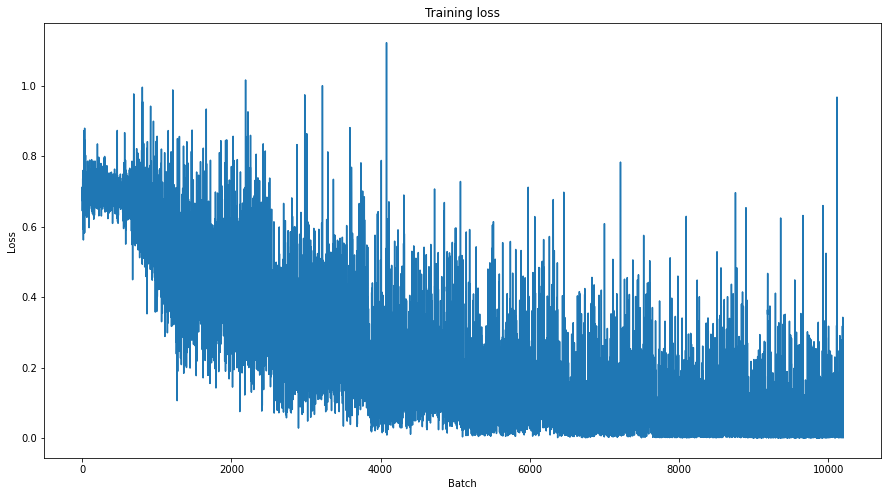

In [51]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [52]:
df2_books = pd.read_csv("books_test.csv")
df2 = pd.read_csv("all_movies_check.csv")

The following 2 boxes are to be run only if you want to test the model on books

In [53]:
num_books = df2_books["0"].count()

d_books2={} 
for k in range (len_def):
  d_books2[df_genres_b["Genre"][k]]=0
  
for i in range(num_books):
  genres=df2_books["1"][i]
  d={}
  genres_array = genres.split(", ")
  num_genres = (genres).count(",")+1
  #print(gener_array_split)
  for genre in range (num_genres):
    for j in range (len_genres):
      if (str(genres_array[genre])==str(df_gen["value"][j])):
        d[df_gen["Genre1"][j]]= genres_array[genre]
        if (len(str(df_gen["Genre2"][j]))>3):
          d[df_gen["Genre2"][j]]=genres_array[genre]
          if (len(str(df_gen["Genre3"][j]))>3):
            d[df_gen["Genre3"][j]]=genres_array[genre]
  for k in d:
    d_books2[k]+=1

print(d_books2)

{'Adventure Books': 91, 'Memoirs/ Biography': 105, 'Funny Books & Stories': 142, 'Crime': 34, 'Fantasy': 117, 'Historical': 39, 'Horror': 61, 'Mystery': 31, 'Romance': 134, 'Science Fiction': 58, 'Short Story Books': 22, 'Thrillers': 133, 'War Books': 14, 'Young Adults': 41, "Children's Books": 238, 'Fiction': 184, 'Graphic Novels': 50, 'Holocaust': 12, 'True Story Books': 32}


In [54]:
pos_data = 0
neg_data = 0
check = []
check_labels = []
genres = []
#n={}

stop_dict = {}
for k in range (len_def):
  stop_dict[df_genres_b["Genre"][k]]=0
  
for i in range(num_books):
  gens=df2_books["1"][i]
  d={}
  genres_array = gens.split(", ")
  num_genres = (gens).count(",")+1
  #print(gener_array_split)
  for genre in range (num_genres):
    for j in range (len_genres):
      if (str(genres_array[genre])==str(df_gen["value"][j])):
        d[df_gen["Genre1"][j]]= genres_array[genre]
        if (len(str(df_gen["Genre2"][j]))>3):
          d[df_gen["Genre2"][j]]=genres_array[genre]
          if (len(str(df_gen["Genre3"][j]))>3):
            d[df_gen["Genre3"][j]]=genres_array[genre]
  #print (d)
  for key in (d):
    for gener_val in range (len_def):
      if (str(key)==str(df_genres_b["Genre"][gener_val])):
        s = "[CLS] Plot: " + df2_books["2"][i] + " Genre definition: "  +str(df_genres_b["definition"][gener_val])+ " [SEP]"
        pos_data+=1
        check.append(s)
        check_labels.append(1)
        genres.append(key)
      else:
        if (stop_dict[key]<(d_books2[key]*1.15)):
          s = "[CLS] Plot: " + df2_books["2"][i] + " Genre definition: "  +str(df_genres_b["definition"][gener_val])+ " [SEP]"
          check.append(s)
          neg_data+=1
          check_labels.append(0)
          stop_dict[key]+=1
          genres.append(key)


print(neg_data)
print(pos_data)

n_d=[]
for key in d_books2:
  n_d.append((key,d_books2[key]))
d2=pd.DataFrame(n_d)
d2.to_csv('books_test_dist.csv', index=False)


1778
1538


The following 2 boxes are to be run only if you want to test the model on movies.

In [ ]:
len_file = df2["Genre1"].count()
df2['Genre1'].value_counts()
frequency_df1 = df2['Genre1'].value_counts()
frequency_df2 = df2['Genre2'].value_counts()
frequency_df3 = df2['Genre3'].value_counts()

distributions = {}
for i in range (23):
  gen = df_genres.Genre[i]
  if (gen in frequency_df1):
    a=frequency_df1[gen]
  else:
    a=0
  if (gen in frequency_df2):
    b=frequency_df2[gen]
  else:
    b=0
  if (gen in frequency_df3):
    c=frequency_df3[gen]
  else:
    c=0
  distributions[gen] = a+b+c

print(distributions) 

{'Action': 245, 'Adventure': 200, 'Animation': 47, 'Biography': 52, 'Comedy': 392, 'Crime': 199, 'Documentary': 23, 'Drama': 524, 'Family': 79, 'Fantasy': 72, 'Film-Noir': 3, 'History': 25, 'Horror': 116, 'Music': 32, 'Musical': 17, 'Mystery': 76, 'Romance': 174, 'Sci-Fi': 82, 'Sport': 29, 'Short': 2, 'Thriller': 166, 'War': 26, 'Western': 7}


In [ ]:
pos_data = 0
neg_data = 0
check = []
p2={}
n2={}
check_labels = []
genres = []
d_new = {} 
stop = 0
for i in range (23):
  gen = df_genres.Genre[i]
  desc = df_genres.definition[i]
  d_new[gen] = 0
  p2[gen]=0
  n2[gen]=0
  stop = 0
  stop_value = (int) (1.15* distributions[gen])
  for j in range(len_file):
    s = "[CLS] Plot: " + df2.Plot[j] + " Genre definition: " + desc + " [SEP]"
    if (df2.Genre1[j]==gen):
      d_new[gen]+=1
      p2[gen]+=1
      pos_data+=1
      check.append(s)
      check_labels.append(1)
      genres.append(gen)
    elif (df2.Genre2[j]==gen):
      d_new[gen]+=1
      pos_data+=1
      p2[gen]+=1
      check.append(s)
      check_labels.append(1)
      genres.append(gen)
    elif (df2.Genre3[j]==gen):
      d_new[gen]+=1
      pos_data+=1
      p2[gen]+=1
      check.append(s)
      check_labels.append(1)
      genres.append(gen)
    else:
      if(stop==stop_value):
        continue
      else:
        check.append(s)
        neg_data+=1
        n2[gen]+=1
        check_labels.append(0)
        genres.append(gen)
        stop+=1

print(d_new)
print((pos_data))
print((neg_data))
print(len(check_labels)==len(check))

n_d=[]
for key in d_new:
  n_d.append((key, d_new[key],p2[key],n2[key]))
d2=pd.DataFrame(n_d)
d2.to_csv('test_dist.csv', index=False)

{'Action': 245, 'Adventure': 200, 'Animation': 47, 'Biography': 52, 'Comedy': 392, 'Crime': 199, 'Documentary': 23, 'Drama': 524, 'Family': 79, 'Fantasy': 72, 'Film-Noir': 3, 'History': 25, 'Horror': 116, 'Music': 32, 'Musical': 17, 'Mystery': 76, 'Romance': 174, 'Sci-Fi': 82, 'Sport': 29, 'Short': 2, 'Thriller': 166, 'War': 26, 'Western': 7}
2588
2890
True


In [55]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in check]
tokenized_genres = [tokenizer.tokenize(gen) for gen in genres]

Run the next box only if you want to test the model on books

In [56]:
s  = sum([len(i) for i in tokenized_texts])
print(s/(len(tokenized_texts)))
 
labels2 = []
tokenized_texts2 = []
genres2 = []
for i in range(len(tokenized_texts)):
  if (len(tokenized_texts[i])<256):
    tokenized_texts2.append(tokenized_texts[i])
    labels2.append(check_labels[i])
    genres2.append(tokenized_genres[i])

s  = sum([len(i) for i in tokenized_texts2])
print(s/(len(tokenized_texts2)))

max_len = max([len(i) for i in tokenized_texts2])
print(max_len)
print(len(tokenized_texts2))

check_labels = labels2
tokenized_texts = tokenized_texts2
tokenized_genres = genres2

145.37726176115802
128.0100908173562
255
2973


In [57]:
MAX_LEN = 256

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
genre_ids = [tokenizer.convert_tokens_to_ids(j) for j in tokenized_genres]


# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
genre_in = pad_sequences(genre_ids, maxlen=1, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(check_labels)
genre_ins = torch.tensor(genre_in)
  
batch_size = 16  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels, genre_ins)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [58]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels, true_genre = [], [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, b_genre = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  genre_ids = b_genre.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
  true_genre.append(b_genre)

In [59]:
right=0
wrong=0
cnt0=0
cnt1=0
tp=0
tn=0
fp=0
fn=0

with open("end_data.csv", "w") as f:
  for i in range(len(predictions)):
    for j in range(len(predictions[i])):
      f.write(str(predictions[i][j][0]) + "," +str(predictions[i][j][1]) + "," + str(true_labels[i][j]) +"," + str(true_genre[i][j]) +"\n" )
      if (predictions[i][j][0]>predictions[i][j][1]):
        lab=0
        cnt0+=1
      else:
        lab=1
        cnt1+=1
      if (lab==true_labels[i][j]):
        if (lab==1):
          tp+=1
        else:
          tn+=1
        right+=1
      else:
        if (lab==1):
          fp+=1
        else:
          fn+=1
        wrong+=1

right_p = right/(pos_data+neg_data)
wrong_p = wrong/(pos_data+neg_data)

print('Classification accuracy using BERT Fine Tuning: {0:0.2%}'.format(right/(pos_data+neg_data)))
#print('Classification inaccuracy using BERT Fine Tuning: {0:0.2%}'.format(wrong_p))
#print('false positive precentage: {0:0.2%}'.format(fp/(pos_data+neg_data)))
#print('false negative precentage: {0:0.2%}'.format(fn/(pos_data+neg_data)))


Classification accuracy using BERT Fine Tuning: 43.09%
false positive precentage: 41.77%
false negative precentage: 4.79%


In [60]:
from google.colab import files
files.download('end_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>